# HoloLens to C-arm System Calibration

Author: *Tianyu Song*

Email: *tsong11@jhu.edu*
___

This script is written in Python 3 and you also need to install these packages:
* OpenCV 3
* Numpy
* Scipy
* Matplolib

## Step 1: Calibration Between Marker 2 and X-ray Source

Read NDI tracker csv files and Xray image of Marker 1.
#### Note: Do not flip the Xray image

[[194.5, 666.5], [710.5, 476.5], [750.5, 869.5], [361.5, 386.5]]


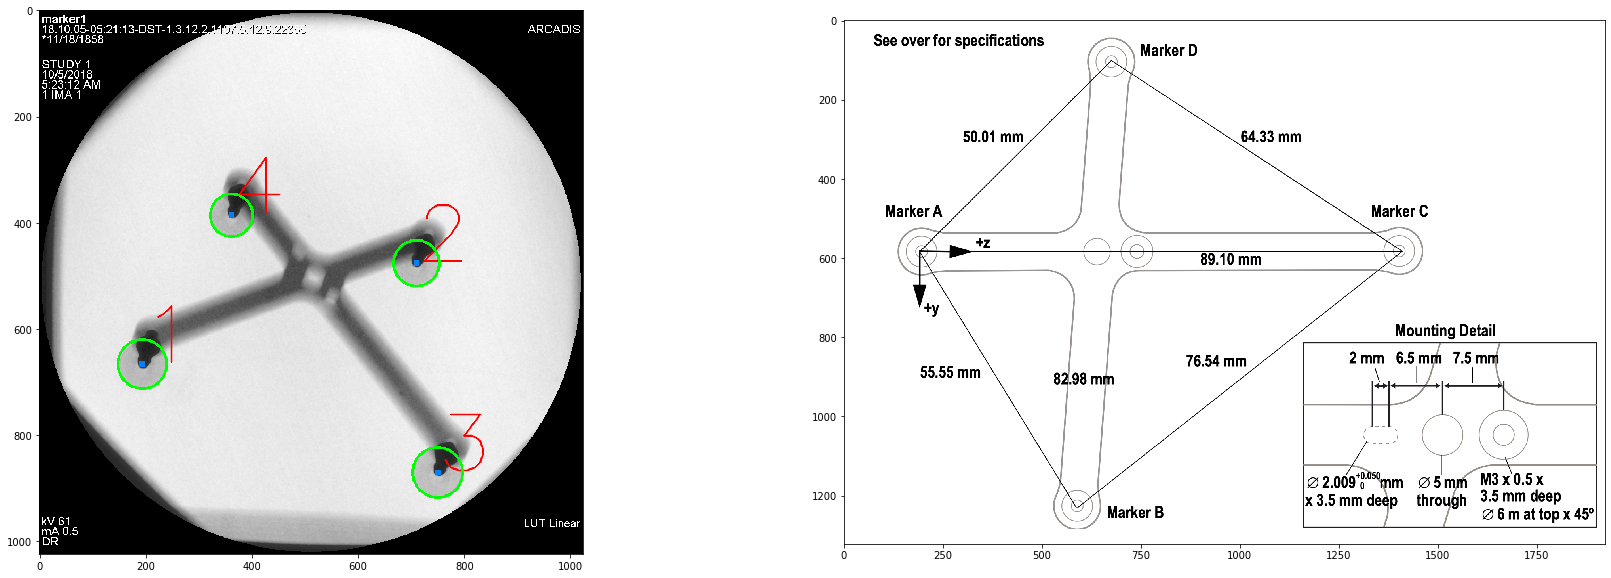

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import csv 

# num = 001 to 007

num = '001'

def rotx(deg):
    rad = float(deg) / 180 * math.pi
    Rx = np.array([[1,0,0],[0,np.cos(rad),-np.sin(rad)],[0,np.sin(rad),np.cos(rad)]])
    return Rx

def roty(deg):
    rad = float(deg) / 180 * math.pi
    Ry = np.array([[np.cos(rad),0,np.sin(rad)],[0,1,0],[-np.sin(rad),0,np.cos(rad)]])
    return Ry

def rotz(deg):
    rad = float(deg) / 180 * math.pi
    Rz = np.array([[np.cos(rad),-np.sin(rad),0],[np.sin(rad),np.cos(rad),0],[0,0,1]])
    return Rz

with open('./Step1Data/Tracker/step1_'+ num + '.csv', mode = 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    csvlist = list(csv_reader)
    # Marker 1
    Rx = csvlist[1][7]
    Ry = csvlist[1][6]
    Rz = csvlist[1][5]
    Tx = csvlist[1][8]
    Ty = csvlist[1][9]
    Tz = csvlist[1][10]

    #Marker 2
    R1x = csvlist[1][19]
    R1y = csvlist[1][18]
    R1z = csvlist[1][17]
    T1x = csvlist[1][20]
    T1y = csvlist[1][21]
    T1z = csvlist[1][22]

Point2D = []
img = cv2.imread('./Step1Data/X/'+num+'.BMP')
flag = False
if flag:
    rows,cols,cn = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
    img = cv2.warpAffine(img,M,(cols,rows))
    
output = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# detect circles in the image
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20,param1=50,param2=26,minRadius=37,maxRadius=50)
font = cv2.FONT_HERSHEY_SIMPLEX
i = 0
# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles_1 = circles
    circles = np.round(circles_1[0, :]).astype("int")
    circles_temp = np.round(circles_1[0, :],1).astype("float")
    for (x_t,y_t,r_t) in circles_temp:
        Point2D.append([x_t,y_t])
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        i += 1
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv2.putText(output , str(i), (x, y-4), font, 5, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

    # show the output image  
    cv2.imwrite('detected_circles_'+ num + '.JPG', output)
    ABCD = cv2.imread('ABCD.PNG')
    f = plt.figure(figsize=(30, 10))
    f.add_subplot(1,2,1)
    plt.imshow(output)
    f.add_subplot(1,2,2)
    plt.imshow(ABCD)
    Point2D = Point2D[0:4]
    print (Point2D)
    p2dict = {}
    p2dict['Point2D'] = Point2D
    sio.savemat('./Step1Data/Step1_P2D_' + num + '.mat',p2dict)

In [3]:
p2d = sio.loadmat('./Step1Data/Step1_P2D_' + num + '.mat')
Point2D = p2d['Point2D']

#### Specify the correspondence

In [4]:
# If you want to run this cell, you should change the number based on the images above
p4 = np.array([0, 0, 0, 1]) # A
p1 = np.array([0,47.38, 28.99, 1]) #B
p3 = np.array([0, 0, 89.10, 1]) #C
p2 = np.array([0, -35.36, 35.36, 1]) #D

p3dict = {}
p3dict['p1'] = p1
p3dict['p2'] = p2
p3dict['p3'] = p3
p3dict['p4'] = p4
sio.savemat('./Step1Data/Step1_P3D_' + num + '.mat',p3dict)

 #### Transform Marker 1 to NDI tracker coordinate frame and store them in Point3D
 #### The correct corresponding 2D points are stored in Point2D
 #### Use OpenCV's SolvePnP to get Xray Source's pose in NDI tracker coordinate frame
 #### Note: The first column of the intrinsics K is flipped

In [5]:
p3d = sio.loadmat('./Step1Data/Step1_P3D_' + num + '.mat')
p2d = sio.loadmat('./Step1Data/Step1_P2D_' + num + '.mat')
Point2D = p2d['Point2D']
p1 = p3d['p1'].reshape(4,1)
p2 = p3d['p2'].reshape(4,1)
p3 = p3d['p3'].reshape(4,1)
p4 = p3d['p4'].reshape(4,1)

Rot_M1 = np.matmul(np.matmul(rotz(Rz) , roty(Ry)) , rotx(Rx))
T_M1 = np.array([float(Tx),float(Ty),float(Tz)]).reshape([3, 1])

Rot_M2 = np.matmul(np.matmul(rotz(R1z) , roty(R1y)) , rotx(R1x))
T_M2 = np.array([float(T1x),float(T1y),float(T1z)]).reshape([3, 1])

T_M12IR = np.concatenate((np.concatenate((Rot_M1, T_M1), axis=1),np.array([[0,0,0,1]])), axis = 0)
T_M22IR = np.concatenate((np.concatenate((Rot_M2, T_M2), axis=1),np.array([[0,0,0,1]])), axis = 0)

p_1 = np.matmul(T_M12IR,p1)
p_2 = np.matmul(T_M12IR,p2)
p_3 = np.matmul(T_M12IR,p3)
p_4 = np.matmul(T_M12IR,p4)
Point3D = np.array([p_1,p_2,p_3,p_4])[:,0:3].astype(np.float32)
Point2D = np.array(Point2D).astype(np.float32)


print (Point2D,'\n \n',Point3D,'\n')
imagePoints = np.ascontiguousarray(Point2D[:,:2]).reshape((4,1,2))
worldPoints = np.ascontiguousarray(Point3D[:,:3]).reshape((4,1,3))

# Define Intrinsic Matrix 
# Inverted X-axis 
K = np.array([[-4363, 0, 512],
              [0, 4363, 512],
              [0, 0, 1]]).astype(np.float32)

dist_coeffs = np.zeros((4,1))
ret, rvec, tvec = cv2.solvePnP(worldPoints,imagePoints,K,None,False,flags=cv2.SOLVEPNP_P3P)

rmat = cv2.Rodrigues(rvec)[0]
RR = rmat.T
TT = np.matmul(-RR,tvec)

T_C2IR = np.concatenate((np.concatenate((RR, TT), axis=1),np.array([[0,0,0,1]])), axis = 0)
T_IR2C = np.linalg.inv(T_C2IR)

T_M22C = np.matmul(T_IR2C, T_M22IR)
T_M12C = np.matmul(T_IR2C,T_M12IR)

np.set_printoptions(suppress=True)

print ('X-ray relative to Tracker: \n \n' , T_C2IR, '\n')
print ('Marker 1 relative to X-ray: \n \n' , T_M12C, '\n')
print ('Marker 2 relative to X-ray: \n \n' , T_M22C, '\n')
print ('L2 distance between Marker 2 and X-ray: \n \n' , np.linalg.norm(T_M22C[0:3,3]), '\n')

# Save to mat file for Matlab
adict = {}
adict['T_M12C'] = T_M12C
adict['T_M22C'] = T_M22C
adict['T_C2IR'] = T_C2IR
sio.savemat('./Step1Data/Step1_' + num + '.mat', adict)

# Check Det
print ('det(T_M12C) = ',np.linalg.det(T_M12C[0:3,0:3]))
print ('det(T_M22C) = ',np.linalg.det(T_M22C[0:3,0:3]))

[[194.5 666.5]
 [710.5 476.5]
 [750.5 869.5]
 [361.5 386.5]] 
 
 [[[  150.92867]
  [  233.03476]
  [-1560.8707 ]]

 [[  114.00822]
  [  274.35654]
  [-1622.6434 ]]

 [[  151.33629]
  [  306.74896]
  [-1581.465  ]]

 [[  117.33   ]
  [  227.765  ]
  [-1604.787  ]]] 

X-ray relative to Tracker: 
 
 [[   -0.02968666    -0.03088341    -0.99908204   715.85159444]
 [   -0.81200001     0.58362569     0.00608681   251.2592357 ]
 [    0.58290196     0.81143532    -0.04240323 -1577.07391706]
 [    0.             0.             0.             1.        ]] 

Marker 1 relative to X-ray: 
 
 [[  0.22867232   0.78292558  -0.57856418  20.69141902]
 [  0.59825067   0.35583004   0.71797014 -17.714825  ]
 [  0.7679877   -0.51030631  -0.38701727 599.00429317]
 [  0.           0.           0.           1.        ]] 

Marker 2 relative to X-ray: 
 
 [[  -0.97658938   -0.06260678   -0.20579982   -1.65855247]
 [  -0.21510898    0.28929968    0.93275604 -672.91242868]
 [   0.00114097    0.95518903   -0.2959942

#### Try to get the average from all the datasets. Note: the first one is bad data

In [6]:
# Average Transformation

def AverageRot(R):
    
    n = R.shape[2]
    tmp = np.zeros((3,3))
    for i in range (n):
        tmp += R[0:3,0:3,i] 
    
    Rbarre = tmp / n
    RTR = np.matmul(Rbarre.T, Rbarre)
    D, V = np.linalg.eig(RTR)
    D = np.diag(np.flipud(D))
    V = np.fliplr(V)
    sqrtD = np.sqrt(np.linalg.inv(D))
    if(np.linalg.det(Rbarre[0:3,0:3])<0):
        sqrtD[2,2] = -sqrtD[2,2]
        
    Ravg = np.matmul(Rbarre, np.matmul(np.matmul(V,sqrtD),V.T))
    return Ravg

def AverageTrans(H):
    n = H.shape[2]
    R_avg = AverageRot(H[0:3,0:3,:])
    T_sum = np.zeros((3,1))
    for i in range (n):
        T_temp = H[0:3,3,i].reshape([3, 1])
        T_sum += T_temp
    
    T_avg = T_sum / n
    Havg = np.concatenate((np.concatenate((R_avg, T_avg), axis=1),np.array([[0,0,0,1]])), axis = 0)    
    return Havg

NN = 8
All_T_M22C = np.zeros((4,4, NN))
for i in range (1,NN):
    Step1Data = sio.loadmat('./Step1Data/Step1_00'+ str(i) + '.mat')
    All_T_M22C[:,:,i] = Step1Data['T_M22C']
    print (All_T_M22C[:,:,i])

T_Data = sio.loadmat('./All_T_M22C_O.mat')
All_T_M22C_ = T_Data['All_T_M22C']
# First one is bad data
All_T_M22C = All_T_M22C_[:,:,1:8]

#T_All ={}
#T_All['All_T_M22C'] = All_T_M22C
# sio.savemat('./All_T_M22C.mat', T_All)
T_M22C = AverageTrans(All_T_M22C)
Tdict = {}
Tdict['T_M22C'] = T_M22C
sio.savemat('./Step1.mat', Tdict)
print ('Average Marker 2 relative to X-ray: \n \n' , T_M22C, '\n')

[[  -0.97658938   -0.06260678   -0.20579982   -1.65855247]
 [  -0.21510898    0.28929968    0.93275604 -672.91242868]
 [   0.00114097    0.95518903   -0.29599427  775.77579615]
 [   0.            0.            0.            1.        ]]
[[  -0.97389523   -0.10607096   -0.20069139   -7.05311946]
 [  -0.22318117    0.285981      0.93188252 -673.59839319]
 [  -0.04145175    0.95234648   -0.30218857  775.3731009 ]
 [   0.            0.            0.            1.        ]]
[[  -0.97515824   -0.0965383    -0.19936592   -8.53073282]
 [  -0.21865592    0.27551928    0.9360976  -673.72408068]
 [  -0.03544011    0.95643582   -0.28978356  769.36154589]
 [   0.            0.            0.            1.        ]]
[[  -0.9749794    -0.08908451   -0.20366422   -6.60564843]
 [  -0.22093039    0.28695332    0.93211993 -671.69374143]
 [  -0.02459532    0.95379334   -0.29945505  776.02673208]
 [   0.            0.            0.            1.        ]]
[[  -0.97570759   -0.08706841   -0.20103181   -6.186

## Step 2: Calibration between X-ray source and HoloLens

Read HoloLens Pose data and NDI tracker data and print the number of dataset

In [7]:
import json
import os
from os import listdir

dataset = "3"

def list_files1(directory, extension):
    return (f for f in listdir(directory) if f.endswith('.' + extension))

M2 = list_files1("./Step2Data/" + dataset + "/NDI","csv")
Holo = list_files1("./Step2Data/" + dataset + "/Holo","json")
M2list = [file for file in M2]
Hlist = [file for file in Holo]
M2list.sort()
Hlist.sort()

csv_processedlist = []
json_processedlist = []
print (len(M2list))
print (len(Hlist))
for i in range(len(M2list)):
    with open('./Step2Data/' + dataset + '/NDI/' + M2list[i], mode = 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        csvlist = list(csv_reader)
        # Marker 2
        Rx = csvlist[1][7]
        Ry = csvlist[1][6]
        Rz = csvlist[1][5]
        Tx = csvlist[1][8]
        Ty = csvlist[1][9]
        Tz = csvlist[1][10]
        csv_processedlist.append([Rx, Ry, Rz, Tx, Ty, Tz])

    j_data = json.load(open('./Step2Data/' + dataset + '/Holo/' + Hlist[i],"r"))

    HRx = j_data["Rx"]
    HRy = j_data["Ry"]
    HRz = j_data["Rz"]
    HTx = j_data["Tx"]
    HTy = j_data["Ty"]
    HTz = j_data["Tz"]
    json_processedlist.append([HRx, HRy, HRz, HTx, HTy, HTz])

with open('./Step2Data/' + dataset + '/NDI.csv', 'w') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',')
    for i in range(len(M2list)):
        csv_writer.writerow(csv_processedlist[i])

with open('./Step2Data/' + dataset + '/Holo.csv', 'w') as csvfile:
    csv_writer = csv.writer(csvfile, delimiter=',')
    for i in range(len(Hlist)):
        csv_writer.writerow(json_processedlist[i])

121
121


#### Generate transformation matrices, starting by 50 pairs of datasets, with step 10, until all pairs are used.
#### Note: Unity is left-handed and the rotation order is ZXY, NDI tracker is right-handed, and the rotation order is XYZ

In [8]:
Step1 = sio.loadmat('./Step1.mat')
T_M22C = Step1['T_M22C']
# Specify how many dataset you want to use
S = 120
step = 10
N = 121

Holo = json_processedlist
M2 = csv_processedlist


flip = np.array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, -1, 0],
        [0, 0, 0, 1] ])

for j in range(S, N, step):
    HoloPose = Holo[0:j]
    M2Pose = M2[0:j]
    h2w = np.zeros((4,4, j))
    C2IR = np.zeros((4,4, j))
    for i in range(j):
        # Create Transformation Matrix h2w
        Rot_Holo = np.matmul(np.matmul(roty(HoloPose[i][1]) , rotx(HoloPose[i][0])) , rotz(HoloPose[i][2]))
        T_Holo = np.array([float(HoloPose[i][3]),float(HoloPose[i][4]),float(HoloPose[i][5])]).reshape([3, 1]) * 1000
        h2w_temp = np.concatenate((np.concatenate((Rot_Holo, T_Holo), axis=1),np.array([[0,0,0,1]])), axis = 0)
        h2w[:,:,i] = np.matmul(np.matmul(flip,h2w_temp),flip)
        # Create Transformation Matrix C2IR
        Rot_M = np.matmul(np.matmul(rotz(M2Pose[i][2]) , roty(M2Pose[i][1])) , rotx(M2Pose[i][0]))
        T_M = np.array([float(M2Pose[i][3]),float(M2Pose[i][4]),float(M2Pose[i][5])]).reshape([3, 1])
        M22IR = np.concatenate((np.concatenate((Rot_M, T_M), axis=1),np.array([[0,0,0,1]])), axis = 0)
        C2IR[:,:,i] = np.matmul(M22IR , np.linalg.inv(T_M22C))
        if i == j-1:
            # Save to Mat file
            bdict = {}
            bdict['H2W'] = h2w
            bdict['C2IR'] = C2IR
            sio.savemat('./Tracker_Xray_Extrinsics/Extrinsics_' + str(j) + '.mat', bdict)

# Check Det
print ('det(T_M22C) = ',np.linalg.det(T_M22C[0:3,0:3]))
print ('det(M22IR) = ',np.linalg.det(M22IR[0:3,0:3]))
print ('det(C2IR) = ',np.linalg.det(C2IR[0:3,0:3,2]))
print ('det(h2w) = ',np.linalg.det(h2w[0:3,0:3,2]))

det(T_M22C) =  1.0000000000000004
det(M22IR) =  0.9999999999999999
det(C2IR) =  0.9999999999999997
det(h2w) =  1.0


## Final Step: Hand-Eye Calibration

### Please run HandEyeCalibration.m in Matlab

